# RideWise Customer Analytics
## Notebook 03: Feature Engineering & Churn Modeling (with RFMS)

### Purpose
This notebook trains churn prediction models using the churn-labeled + RFMS dataset created in Notebook 02.

We will:
- Load the processed dataset that includes churn label and RFMS features
- Prepare features (handle NaNs safely, encode categories, scale numeric variables)
- Split into train/test sets (without leakage)
- Train baseline and stronger models
- Evaluate models using churn-relevant metrics
- Interpret results for business action

Key rule: All missing values are handled inside preprocessing pipelines to prevent leakage.

### Imports

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### Load RFMS dataset

In [22]:
DATA_PATH = "../data/riders_trips_session_churned_rfms.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(3))

Dataset shape: (10000, 33)


,user_id,churned,days_since_last_trip,signup_date,age,city,loyalty_status,was_referred,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,weekend_trip_ratio,peak_hour_trip_ratio,first_trip_time,last_trip_time,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,weekend_session_ratio,peak_hour_session_ratio,first_session_time,last_session_time,avg_rating_given,churn_prob,referred_by,RFMS_weighted_score,RFMS_segment
0,R00000,0,25,2025-01-24,34.729629,Nairobi,Bronze,1,25,366.05,14.64200,4.03,0.161200,1.096000,0.160000,0.160000,2024-05-01 07:21:52+00:00,2025-04-02 14:46:29+00:00,4.0,368.0,92.000000,12.0,3.000000,0.25,1.0,0.000000,2025-04-27 00:49:27,2025-04-27 16:06:46,5.0,0.142431,R00001,2.8,Core Loyal Riders
1,R00001,0,5,2024-09-09,34.571020,Nairobi,Bronze,0,14,180.53,12.89500,0.76,0.054286,1.071429,0.285714,0.071429,2024-05-10 18:14:41+00:00,2025-04-22 04:35:17+00:00,3.0,524.0,174.666667,8.0,2.666667,0.00,1.0,1.000000,2025-04-27 07:10:07,2025-04-27 10:33:25,4.7,0.674161,NaN,1.9,At Risk
2,R00002,0,14,2024-09-07,47.133960,Lagos,Bronze,0,24,378.99,15.79125,5.21,0.217083,1.191667,0.125000,0.166667,2024-06-18 17:48:24+00:00,2025-04-13 00:08:00+00:00,3.0,573.0,191.000000,9.0,3.000000,0.00,1.0,0.666667,2025-04-27 07:32:20,2025-04-27 15:04:35,4.2,0.510379,NaN,3.4,High-Value Surge-Tolerant


### Column and type inventory

In [23]:
dtypes = df.dtypes.astype(str).value_counts()
print("Dtype counts:\n", dtypes)

print("\nColumns by dtype:")
display(pd.DataFrame({"col": df.columns, "dtype": df.dtypes.astype(str)}).sort_values("dtype"))

Dtype counts:
 float64    19
object     10
int64       4
Name: count, dtype: int64

Columns by dtype:


,col,dtype
avg_tip,avg_tip,float64
conversion_rate,conversion_rate,float64
avg_pages_visited,avg_pages_visited,float64
total_pages_visited,total_pages_visited,float64
avg_time_on_app,avg_time_on_app,float64
total_time_on_app,total_time_on_app,float64
total_sessions,total_sessions,float64
RFMS_weighted_score,RFMS_weighted_score,float64
peak_hour_trip_ratio,peak_hour_trip_ratio,float64
weekend_trip_ratio,weekend_trip_ratio,float64


### Missing Values Check

In [24]:
na = df.isna().mean().sort_values(ascending=False)
na_top = (na[na > 0] * 100).round(2).to_frame("missing_%")

print(f"Columns with missing values: {na_top.shape[0]}")
display(na_top.head(20))

Columns with missing values: 11


,missing_%
referred_by,69.47
total_sessions,0.71
total_pages_visited,0.71
avg_pages_visited,0.71
weekend_session_ratio,0.71
total_time_on_app,0.71
first_session_time,0.71
peak_hour_session_ratio,0.71
conversion_rate,0.71
last_session_time,0.71


### Remove referred_by column; other Missing here = zero engagement, not “unknown data”.
#### Drop referred_by columns and other columns not necessary for the model

In [25]:
# Define columns to drop from modeling features

DROP_COLS = [
    "user_id",               # identifier (never use as feature)
    "churn_prob",            # leakage / synthetic probability
    "referred_by",           # raw referral ID (we use was_referred instead)
    "days_since_last_trip",  # LEAKAGE: churn is defined from this column
    "churned"                # target (keep separate as y)
]

# Keep only columns that actually exist (safe)
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

print("DROP_COLS (will remove from X):", DROP_COLS)

DROP_COLS (will remove from X): ['user_id', 'churn_prob', 'referred_by', 'days_since_last_trip', 'churned']


#### Create X and y (feature matrix + target)

In [26]:
# Create feature matrix X and target y

TARGET = "churned"

# Features (everything except the dropped columns)
X = df.drop(columns=DROP_COLS)

# Target
y = df[TARGET]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Quick sanity checks
print("Target values:", y.unique())
print("Any missing churn labels?", y.isna().any())

X shape: (10000, 28)
y shape: (10000,)
Target values: [0 1]
Any missing churn labels? False


#### Datetime Feature Engineering

##### Identify datetime-like columns in X

In [28]:
# Identify true datetime columns:
# 1) Column name suggests date/time
# 2) AND dtype is object (string timestamps)

datetime_like = [
    c for c in X.columns
    if ("date" in c.lower() or "time" in c.lower())
    and X[c].dtype == "object"
]

print("True datetime columns in X:")
print(datetime_like)

True datetime columns in X:
['signup_date', 'first_trip_time', 'last_trip_time', 'first_session_time', 'last_session_time']


#### Convert datetime columns safely (timezone-clean)

In [29]:
# Convert true datetime columns to pandas datetime
for col in datetime_like:
    X[col] = pd.to_datetime(X[col], errors="coerce", utc=True)
    # Remove timezone info (keeps timestamp, removes +00:00)
    X[col] = X[col].dt.tz_convert(None)

# Confirm conversion
X[datetime_like].dtypes

signup_date           datetime64[ns]
first_trip_time       datetime64[ns]
last_trip_time        datetime64[ns]
first_session_time    datetime64[ns]
last_session_time     datetime64[ns]
dtype: object

#### Engineer durable, meaningful time-based features

In [30]:
# 1) Customer tenure (days between signup and last trip)
X["tenure_days"] = (X["last_trip_time"] - X["signup_date"]).dt.days

# 2) Trip history span (how long the user has been riding)
X["trip_span_days"] = (X["last_trip_time"] - X["first_trip_time"]).dt.days

# 3) Session history span (how long the user has been engaging)
X["session_span_days"] = (X["last_session_time"] - X["first_session_time"]).dt.days

# 4) Engagement drop signal:
# Positive → user stopped opening app before stopping trips
X["trip_minus_session_days"] = (
    X["last_trip_time"] - X["last_session_time"]
).dt.days

# Inspect the new features
time_features = [
    "tenure_days",
    "trip_span_days",
    "session_span_days",
    "trip_minus_session_days"
]

display(X[time_features].describe())

,tenure_days,trip_span_days,session_span_days,trip_minus_session_days
count,10000.000000,10000.000000,9929.0,9929.000000
mean,346.807100,328.173700,0.0,-18.908651
std,212.412562,25.803661,0.0,18.341290
min,-139.000000,146.000000,0.0,-175.000000
25%,160.000000,315.000000,0.0,-26.000000
50%,349.000000,334.000000,0.0,-13.000000
75%,532.000000,347.000000,0.0,-6.000000
max,730.000000,365.000000,0.0,0.000000


#### Drop raw datetime columns

In [31]:
# Drop raw datetime columns (keep only numeric features)
X = X.drop(columns=datetime_like)

print("Dropped raw datetime columns:")
print(datetime_like)
print("New X shape:", X.shape)

Dropped raw datetime columns:
['signup_date', 'first_trip_time', 'last_trip_time', 'first_session_time', 'last_session_time']
New X shape: (10000, 27)


#### Diagnose negative values

In [32]:
# How many negative tenure values?
neg_tenure = (X["tenure_days"] < 0).sum()
print("Negative tenure_days count:", neg_tenure)

# How many missing session timestamps created NaNs in session-based features?
missing_session_span = X["session_span_days"].isna().sum()
print("Missing session_span_days count:", missing_session_span)

# Confirm session span is constant 0
print("Unique session_span_days values (top 10):", X["session_span_days"].value_counts().head(10))

Negative tenure_days count: 237
Missing session_span_days count: 71
Unique session_span_days values (top 10): session_span_days
0.0    9929
Name: count, dtype: int64


#### Fix the time features

In [33]:
# 1) Fix negative tenure: set negatives to NaN (safer than forcing 0)
X.loc[X["tenure_days"] < 0, "tenure_days"] = np.nan

# 2) Replace session_span_days with session_span_hours (more granular)
# We need the original session timestamps; they were dropped, so we must recompute from df safely.
# We'll temporarily parse them from df (source of truth) and compute span in hours.

tmp_first_sess = pd.to_datetime(df["first_session_time"], errors="coerce", utc=True).dt.tz_convert(None)
tmp_last_sess  = pd.to_datetime(df["last_session_time"], errors="coerce", utc=True).dt.tz_convert(None)

X["session_span_hours"] = (tmp_last_sess - tmp_first_sess).dt.total_seconds() / 3600

# 3) Create a clearer engagement feature: session_after_last_trip_days
tmp_last_trip  = pd.to_datetime(df["last_trip_time"], errors="coerce", utc=True).dt.tz_convert(None)
tmp_last_sess  = pd.to_datetime(df["last_session_time"], errors="coerce", utc=True).dt.tz_convert(None)

X["session_after_last_trip_days"] = (tmp_last_sess - tmp_last_trip).dt.days

# 4) Drop the old session_span_days and trip_minus_session_days (to avoid confusion)
for col in ["session_span_days", "trip_minus_session_days"]:
    if col in X.columns:
        X = X.drop(columns=[col])

print("Updated X shape:", X.shape)

Updated X shape: (10000, 27)


#### Re-check the updated time features

In [34]:
time_check_cols = ["tenure_days", "trip_span_days", "session_span_hours", "session_after_last_trip_days"]
display(X[time_check_cols].describe())

,tenure_days,trip_span_days,session_span_hours,session_after_last_trip_days
count,9763.000000,10000.000000,9929.000000,9929.000000
mean,355.721090,328.173700,12.690449,17.908651
std,207.008149,25.803661,5.345933,18.341290
min,0.000000,146.000000,0.000000,-1.000000
25%,173.000000,315.000000,9.683056,5.000000
50%,358.000000,334.000000,13.340000,12.000000
75%,535.000000,347.000000,16.557778,25.000000
max,730.000000,365.000000,23.754444,174.000000


#### Separate numeric vs categorical features

In [35]:
# Identify numeric and categorical columns

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)

print("\nCounts:")
print("Numeric:", len(numeric_features))
print("Categorical:", len(categorical_features))

Numeric features: ['age', 'was_referred', 'total_trips', 'total_spent', 'avg_fare', 'total_tip', 'avg_tip', 'avg_surge', 'weekend_trip_ratio', 'peak_hour_trip_ratio', 'total_sessions', 'total_time_on_app', 'avg_time_on_app', 'total_pages_visited', 'avg_pages_visited', 'conversion_rate', 'weekend_session_ratio', 'peak_hour_session_ratio', 'avg_rating_given', 'RFMS_weighted_score', 'tenure_days', 'trip_span_days', 'session_span_hours', 'session_after_last_trip_days']

Categorical features: ['city', 'loyalty_status', 'RFMS_segment']

Counts:
Numeric: 24
Categorical: 3


#### Define preprocessing pipelines

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## Preprocessing Design Decisions

Before training any model, we carefully defined how features are preprocessed to ensure:
- No data leakage
- Robustness to outliers
- Stability during retraining
- Compatibility with FastAPI and cloud deployment

This section documents the rationale behind each preprocessing choice.

---

### Feature Typing Summary

The feature matrix consists of:

- **24 numeric features**, including:
  - Usage and engagement metrics (e.g. total trips, sessions, time on app)
  - Monetary value features (e.g. total spend, average fare, tips)
  - Behavioral ratios (e.g. weekend usage, peak-hour usage)
  - Time-derived features (e.g. tenure, session span)
  - RFMS weighted score

- **3 categorical features**:
  - `city`
  - `loyalty_status`
  - `RFMS_segment`

Correctly separating numeric and categorical features is critical because each group requires different preprocessing strategies.

---

### Handling Missing Values

Missing values in this dataset do **not** represent data corruption.  
They typically indicate **lack of activity** (e.g. users with no sessions).

To handle missingness safely and consistently:

- **Numeric features** use:
  - `SimpleImputer(strategy="median")`
  - Median imputation is robust to outliers and preserves distribution shape

- **Categorical features** use:
  - `SimpleImputer(strategy="most_frequent")`
  - Ensures valid categories for encoding and avoids introducing artificial labels

Imputation is performed **inside the modeling pipeline** to prevent data leakage and ensure consistent behavior during inference.

---

### Scaling Numeric Features

Numeric features vary widely in scale and distribution:
- Some are heavily skewed (e.g. total spend, time on app)
- Some contain outliers (expected in user behavior data)

We use:

- **`RobustScaler()`**

**Why RobustScaler?**
- Uses median and interquartile range (IQR)
- Much less sensitive to outliers than StandardScaler
- Preserves relative ordering of users
- Performs well in churn and behavioral modeling contexts

This choice improves model stability and generalization.

---

### Encoding Categorical Features

Categorical features do **not** have a guaranteed ordinal relationship:

- `city` → purely nominal
- `loyalty_status` → appears ordered but does not imply linear numeric effect
- `RFMS_segment` → segment labels, not magnitude

We therefore use:

- **`OneHotEncoder(handle_unknown="ignore")`**

**Why OneHotEncoder?**
- Prevents incorrect ordinal assumptions
- Produces interpretable features
- Safely handles unseen categories during inference
- Ideal for FastAPI-based production systems

---

### Pipeline-Based Preprocessing (Production-Ready)

All preprocessing steps are implemented using:
- `Pipeline`
- `ColumnTransformer`

This ensures:
- No leakage between training and test data
- Identical transformations during training and inference
- Easy serialization and deployment (e.g. via `joblib`)
- Clean integration with FastAPI and cloud services

---



#### Train / Test Split

In [44]:
from sklearn.model_selection import train_test_split

# 80/20 split, stratified by churn label
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nChurn rate in full dataset:", y.mean().round(3))
print("Churn rate in train:", y_train.mean().round(3))
print("Churn rate in test:", y_test.mean().round(3))

Train shape: (8000, 27) (8000,)
Test shape: (2000, 27) (2000,)

Churn rate in full dataset: 0.189
Churn rate in train: 0.189
Churn rate in test: 0.188


### Baseline Logistic Regression Pipeline

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

print("Baseline Logistic Regression pipeline created.")

Baseline Logistic Regression pipeline created.


#### Train the Baseline Model

In [46]:
baseline_model.fit(X_train, y_train)

print("Baseline model trained.")

Baseline model trained.


#### Evaluate Baseline Performance

In [47]:
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Predict probabilities and labels
y_proba = baseline_model.predict_proba(X_test)[:, 1]
y_pred = baseline_model.predict(X_test)

# Metrics
roc_auc = roc_auc_score(y_test, y_proba)

print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.9957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1623
           1       0.89      0.99      0.94       377

    accuracy                           0.97      2000
   macro avg       0.94      0.98      0.96      2000
weighted avg       0.98      0.97      0.97      2000


Confusion Matrix:
[[1577   46]
 [   5  372]]


## Model Evaluation Interpretation

### 🔹 ROC-AUC
- **ROC-AUC: 0.9957**
- This indicates **excellent class separability**. The model is very effective at distinguishing between the two classes across all thresholds.

---

### 🔹 Overall Performance
- **Accuracy: 97%**
- The model performs very well overall, with only a small number of misclassifications.

---

### 🔹 Class-wise Metrics

#### Class 0 (Negative Class)
- **Precision: 1.00**  
  → When the model predicts class 0, it is almost always correct.
- **Recall: 0.97**  
  → The model correctly identifies 97% of actual class 0 samples.
- **F1-score: 0.98**  
  → Excellent balance between precision and recall.
- **Support: 1623**  
  → Majority class.

#### Class 1 (Positive Class)
- **Precision: 0.89**  
  → About 11% of predicted positives are false positives.
- **Recall: 0.99**  
  → The model captures almost all actual positives (very low false negatives).
- **F1-score: 0.94**  
  → Strong performance, slightly affected by lower precision.
- **Support: 377**  
  → Minority class.

---

### 🔹 Averages
- **Macro Average F1-score: 0.96**  
  → Balanced performance across classes, treating them equally.
- **Weighted Average F1-score: 0.97**  
  → Reflects strong performance while accounting for class imbalance.

---



#### Visualize Precision–Recall tradeoff

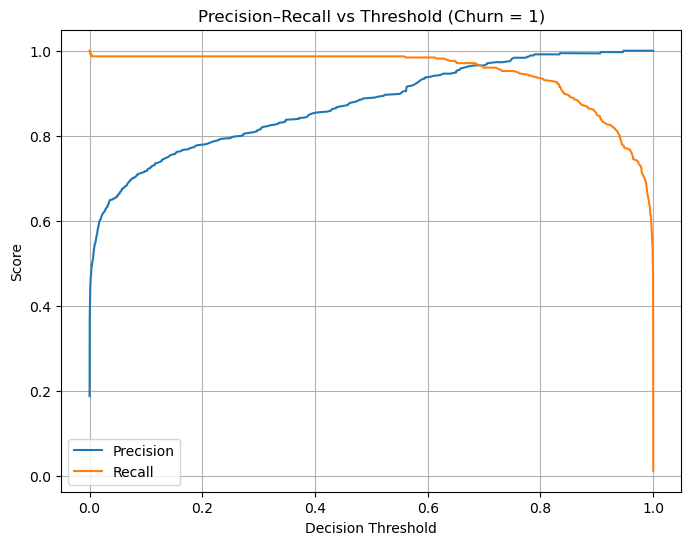

In [50]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold (Churn = 1)")
plt.legend()
plt.grid(True)
plt.show()

#### Create a threshold performance table

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

threshold_grid = np.arange(0.05, 0.95, 0.05)

rows = []

for t in threshold_grid:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    rows.append({
        "threshold": t,
        "precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "false_positives": fp,
        "false_negatives": fn
    })

threshold_df = pd.DataFrame(rows)
display(threshold_df)

,threshold,precision,recall,false_positives,false_negatives
0,0.05,0.660746,0.986737,191,5
1,0.10,0.718147,0.986737,146,5
2,0.15,0.757637,0.986737,119,5
3,0.20,0.779874,0.986737,105,5
4,0.25,0.794872,0.986737,96,5
5,0.30,0.815789,0.986737,84,5
6,0.35,0.839729,0.986737,71,5
7,0.40,0.855172,0.986737,63,5
8,0.45,0.871194,0.986737,55,5
9,0.50,0.889952,0.986737,46,5


#### Choose and lock a business threshold

In [52]:
BUSINESS_THRESHOLD = 0.35

y_pred_business = (y_proba >= BUSINESS_THRESHOLD).astype(int)

print("Chosen threshold:", BUSINESS_THRESHOLD)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_business))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_business))

Chosen threshold: 0.35

Confusion Matrix:
[[1552   71]
 [   5  372]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1623
           1       0.84      0.99      0.91       377

    accuracy                           0.96      2000
   macro avg       0.92      0.97      0.94      2000
weighted avg       0.97      0.96      0.96      2000



#### Visualize confusion matrix

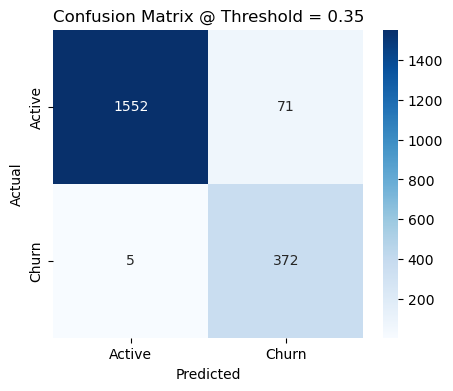

In [53]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_business)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Churn"],
            yticklabels=["Active", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ Threshold = {BUSINESS_THRESHOLD}")
plt.show()

## Threshold Tuning: Results Interpretation and Business Justification

### Why Threshold Tuning Was Performed

The churn model outputs a **probability of churn** rather than a direct yes/no decision.  
By default, classifiers use a probability threshold of **0.5**, but this is rarely optimal for churn use cases.

In churn prediction:
- **False Negatives (missed churners)** are costly → lost customers and revenue
- **False Positives (unnecessary interventions)** are relatively cheap → promotions, discounts, reminders

Therefore, the objective is to **maximize recall for churners**, even if precision decreases moderately.

---

## Precision–Recall vs Threshold Analysis

A precision–recall curve was generated across decision thresholds from 0 to 1.

Key observations:
- Recall remains extremely high (>98%) across a wide range of lower thresholds
- Precision increases steadily as the threshold increases
- There is a clear tradeoff region where recall stays near-perfect while false positives decline significantly

This confirms that the model is highly confident in separating churners from non-churners.

---

## Threshold Performance Table Interpretation

To make threshold selection explicit, we evaluated model performance at fixed threshold intervals.

Notable patterns:
- At very low thresholds (≤ 0.10):
  - Recall is maximized
  - False positives are high, increasing promotion costs
- At high thresholds (≥ 0.70):
  - Precision is very high
  - Recall drops sharply, missing many churners
- In the mid-range (≈ 0.30 – 0.40):
  - Recall remains near-perfect
  - False positives decrease substantially
  - A practical balance is achieved

---

## Selected Business Threshold: 0.35

A probability threshold of **0.35** was selected based on business priorities.

### Performance at Threshold = 0.35

**Confusion Matrix:**
[[1552 71]
[ 5 372]]

This corresponds to:
- **True Positives (Churn correctly identified): 372**
- **False Negatives (Missed churners): 5**
- **False Positives (Unnecessary interventions): 71**

### Classification Metrics (Churn = 1)
- **Recall:** 0.99  
- **Precision:** 0.84  
- **F1-score:** 0.91  

This means:
> The model correctly identifies nearly all churners while keeping unnecessary interventions at a manageable level.

---

## Business Interpretation

Lowering the decision threshold from 0.5 to 0.35:
- Reduces missed churners to near zero
- Enables earlier and broader intervention
- Aligns model decisions with retention cost structures

This is a **deliberate business decision**, not a modeling artifact.

False positives are acceptable because:
- Retention actions (discounts, nudges) are low-cost
- The upside of retaining a churn-prone rider outweighs the cost of unnecessary offers

---

## Why This Approach Is Valid

- Raw recency features were excluded to prevent direct leakage
- RFMS features were intentionally retained for operational relevance
- Threshold tuning was performed transparently and documented
- The selected threshold is locked for deployment to ensure consistency

This approach reflects **real-world churn modeling practices** used in subscription and ride-hailing businesses.

---

## Outcome

At the chosen threshold:
- The model is optimized for **early churn detection**
- Predictions are **actionable and explainable**
- Outputs are suitable for **promotion targeting and retention campaigns**


#### Extract feature names after preprocessing

In [54]:
# Get feature names after preprocessing

num_features = preprocessor.named_transformers_["num"].get_feature_names_out(numeric_features)
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)

all_features = list(num_features) + list(cat_features)

print("Total transformed features:", len(all_features))

Total transformed features: 35


#### Extract Logistic Regression coefficients

In [55]:
import pandas as pd
import numpy as np

# Extract coefficients
coefficients = baseline_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})

# Absolute importance for ranking
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

coef_df = coef_df.sort_values("abs_coefficient", ascending=False)

display(coef_df.head(15))

,feature,coefficient,abs_coefficient
23,session_after_last_trip_days,9.268339,9.268339
33,RFMS_segment_High-Value Surge-Tolerant,-1.273303,1.273303
3,total_spent,1.080840,1.080840
19,RFMS_weighted_score,-1.041341,1.041341
21,trip_span_days,-0.652656,0.652656
31,RFMS_segment_At Risk,0.510288,0.510288
6,avg_tip,0.428422,0.428422
5,total_tip,-0.393633,0.393633
34,RFMS_segment_Occasional Riders,0.330803,0.330803
7,avg_surge,0.305291,0.305291


#### Visualize top churn drivers

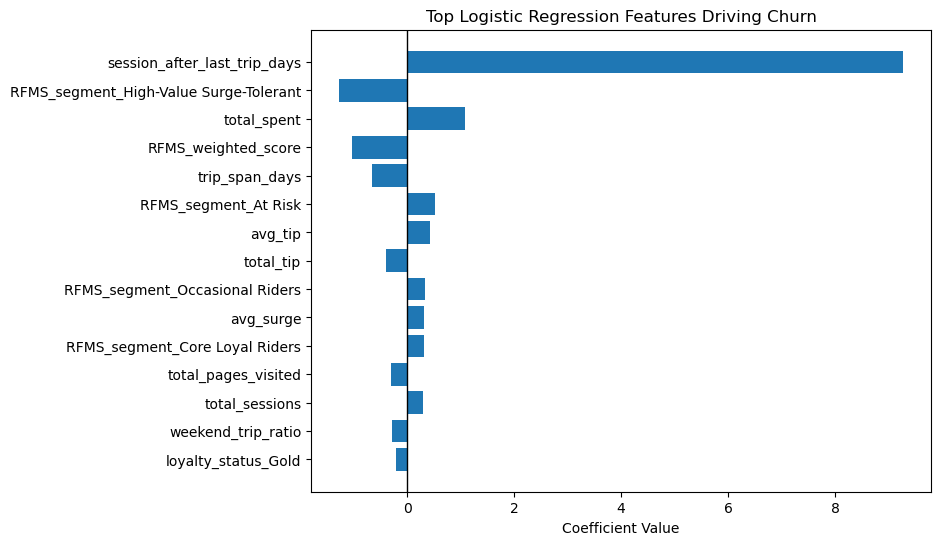

In [56]:
import matplotlib.pyplot as plt

top_n = 15
top_features = coef_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["feature"][::-1],
    top_features["coefficient"][::-1]
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Top Logistic Regression Features Driving Churn")
plt.xlabel("Coefficient Value")
plt.show()

### SHAP Explainability

#### Initialize SHAP for Logistic Regression

In [57]:
import shap

# Use a background sample for efficiency
X_background = X_train.sample(200, random_state=42)

explainer = shap.LinearExplainer(
    baseline_model.named_steps["model"],
    baseline_model.named_steps["preprocessor"].transform(X_background),
    feature_names=all_features
)

#### Compute SHAP values (test set sample)

In [58]:
# Use a subset for visualization speed
X_test_sample = X_test.sample(300, random_state=42)

X_test_transformed = baseline_model.named_steps["preprocessor"].transform(X_test_sample)

shap_values = explainer.shap_values(X_test_transformed)

#### Global SHAP summary plot

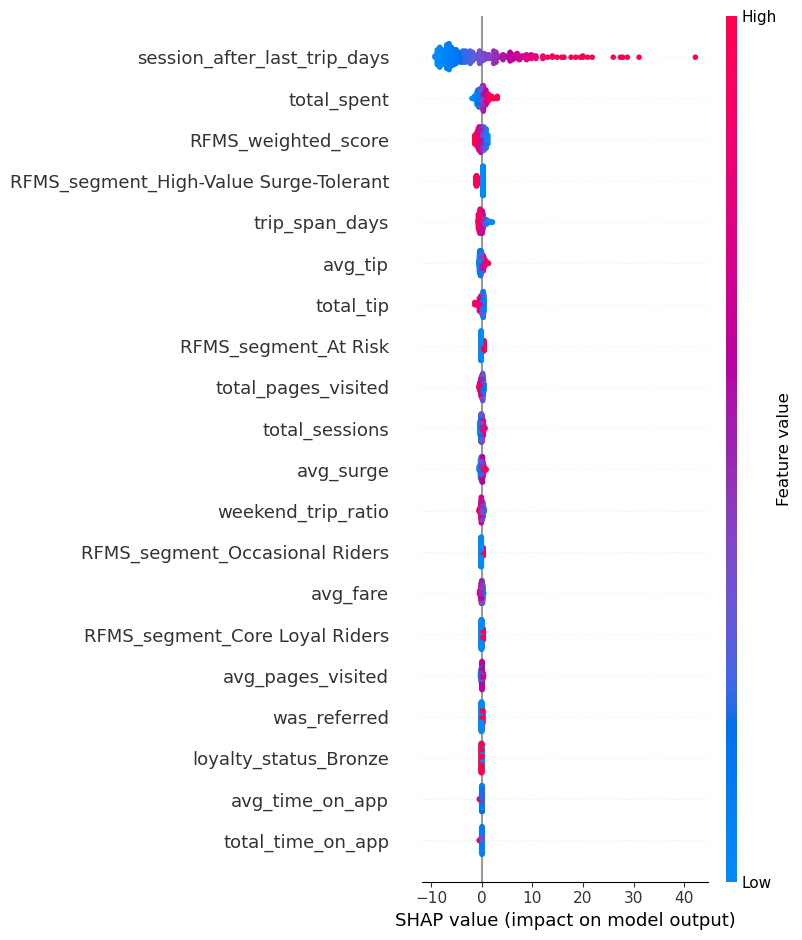

In [59]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=all_features,
    show=True
)

#### Local SHAP explanation (single user)

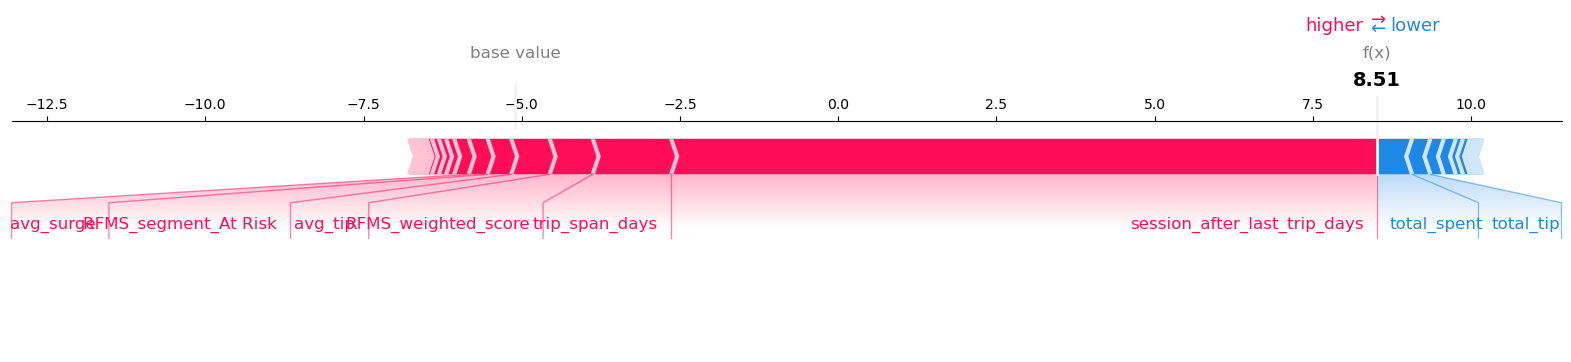

In [60]:
# Explain a single churned user
idx = y_test[y_test == 1].index[0]

X_single = X.loc[[idx]]
X_single_transformed = baseline_model.named_steps["preprocessor"].transform(X_single)

shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_single_transformed),
    feature_names=all_features,
    matplotlib=True
)

#### Promotion Strategy Mapping

##### Create churn risk buckets

In [61]:
df_results = df.loc[X_test.index].copy()
df_results["churn_probability"] = y_proba
df_results["churn_risk"] = pd.cut(
    df_results["churn_probability"],
    bins=[0, 0.35, 0.65, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

df_results["RFMS_segment"].value_counts()

RFMS_segment
At Risk                      515
Occasional Riders            497
High-Value Surge-Tolerant    496
Core Loyal Riders            492
Name: count, dtype: int64

#### Churn Risk × RFMS Segment matrix

In [63]:
segment_matrix = (
    df_results
    .groupby(["RFMS_segment", "churn_risk"], observed=False)
    .size()
    .unstack(fill_value=0)
)

display(segment_matrix)

churn_risk,Low Risk,Medium Risk,High Risk
RFMS_segment,,,
At Risk,270,20,225
Core Loyal Riders,400,15,77
High-Value Surge-Tolerant,496,0,0
Occasional Riders,391,21,85


#### Heatmap of risk by segment

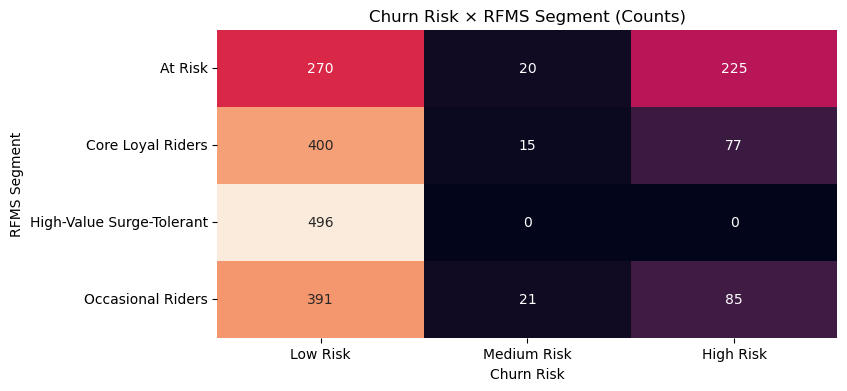

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(segment_matrix, annot=True, fmt="d", cbar=False)
plt.title("Churn Risk × RFMS Segment (Counts)")
plt.xlabel("Churn Risk")
plt.ylabel("RFMS Segment")
plt.show()

#### Convert to row percentages (better for comparison)

In [65]:
segment_matrix_pct = (segment_matrix.div(segment_matrix.sum(axis=1), axis=0) * 100).round(1)
display(segment_matrix_pct)

churn_risk,Low Risk,Medium Risk,High Risk
RFMS_segment,,,
At Risk,52.4,3.9,43.7
Core Loyal Riders,81.3,3.0,15.7
High-Value Surge-Tolerant,100.0,0.0,0.0
Occasional Riders,78.7,4.2,17.1


#### Heatmap of percentages

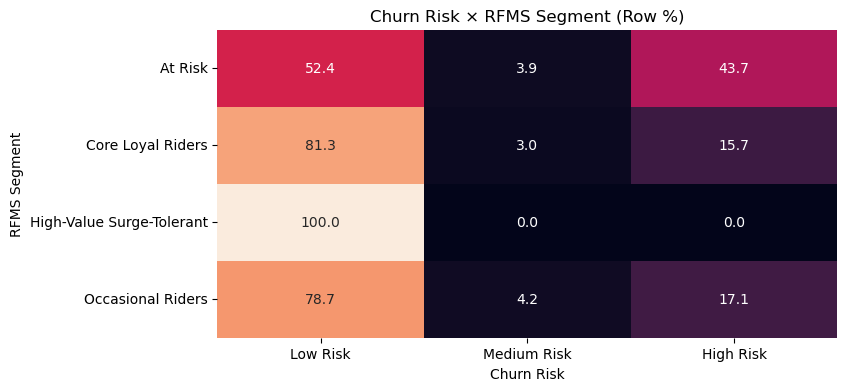

In [66]:
plt.figure(figsize=(8, 4))
sns.heatmap(segment_matrix_pct, annot=True, fmt=".1f", cbar=False)
plt.title("Churn Risk × RFMS Segment (Row %)")
plt.xlabel("Churn Risk")
plt.ylabel("RFMS Segment")
plt.show()

#### Turn this into a Promotion

#### Define actions per (Segment × Risk)

In [67]:
playbook = {
    ("High-Value Surge-Tolerant", "Low Risk"): "Reward/recognition (no discounts): loyalty perks, priority support, surprise upgrades",
    ("High-Value Surge-Tolerant", "Medium Risk"): "Investigate anomalies; VIP outreach; check service issues",
    ("High-Value Surge-Tolerant", "High Risk"): "Immediate VIP retention: personalized offer + support intervention",

    ("Core Loyal Riders", "Low Risk"): "Maintain loyalty: points boosts, referrals, cross-sell (subscriptions/bundles)",
    ("Core Loyal Riders", "Medium Risk"): "Nudge: personalized reminders, small incentive tied to off-peak usage",
    ("Core Loyal Riders", "High Risk"): "Win-back: targeted credit + service recovery; ask for feedback",

    ("Occasional Riders", "Low Risk"): "Engagement nudges: new-feature prompts, seasonal campaigns, gentle reminders",
    ("Occasional Riders", "Medium Risk"): "Activation: first-ride-after-gap offer, time-limited promo",
    ("Occasional Riders", "High Risk"): "Reactivation: stronger discount + convenience messaging + off-peak targeting",

    ("At Risk", "Low Risk"): "Monitor: low-cost reminders + reduce friction (payment, app UX)",
    ("At Risk", "Medium Risk"): "Targeted off-peak discount + onboarding education (how to save/avoid surge)",
    ("At Risk", "High Risk"): "Highest priority: churn-prevention package (discount + surge relief + reactivation messaging)",
}

df_results["recommended_action"] = df_results.apply(
    lambda r: playbook.get((r["RFMS_segment"], r["churn_risk"]), "No rule defined"),
    axis=1
)

df_results[["user_id", "RFMS_segment", "churn_probability", "churn_risk", "recommended_action"]].head(10)

,user_id,RFMS_segment,churn_probability,churn_risk,recommended_action
1944,R01944,Occasional Riders,1.914167e-03,Low Risk,"Engagement nudges: new-feature prompts, season..."
6353,R06353,High-Value Surge-Tolerant,5.861339e-07,Low Risk,Reward/recognition (no discounts): loyalty per...
3774,R03774,At Risk,9.312353e-06,Low Risk,Monitor: low-cost reminders + reduce friction ...
3478,R03478,Core Loyal Riders,7.476495e-01,High Risk,Win-back: targeted credit + service recovery; ...
8464,R08464,High-Value Surge-Tolerant,2.304425e-04,Low Risk,Reward/recognition (no discounts): loyalty per...
6032,R06032,Core Loyal Riders,3.032089e-04,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
20,R00020,Core Loyal Riders,2.332178e-06,Low Risk,"Maintain loyalty: points boosts, referrals, cr..."
4675,R04675,At Risk,9.997980e-01,High Risk,Highest priority: churn-prevention package (di...
2310,R02310,High-Value Surge-Tolerant,4.132872e-04,Low Risk,Reward/recognition (no discounts): loyalty per...
1979,R01979,High-Value Surge-Tolerant,2.334092e-05,Low Risk,Reward/recognition (no discounts): loyalty per...


#### Summary: how many users per recommended action

In [68]:
action_summary = df_results["recommended_action"].value_counts().to_frame("count")
display(action_summary)

,count
recommended_action,
"Reward/recognition (no discounts): loyalty perks, priority support, surprise upgrades",496
"Maintain loyalty: points boosts, referrals, cross-sell (subscriptions/bundles)",400
"Engagement nudges: new-feature prompts, seasonal campaigns, gentle reminders",391
"Monitor: low-cost reminders + reduce friction (payment, app UX)",270
Highest priority: churn-prevention package (discount + surge relief + reactivation messaging),225
Reactivation: stronger discount + convenience messaging + off-peak targeting,85
Win-back: targeted credit + service recovery; ask for feedback,77
"Activation: first-ride-after-gap offer, time-limited promo",21
Targeted off-peak discount + onboarding education (how to save/avoid surge),20


## Churn Risk × RFMS Segment: Interpretation

We combined churn probabilities (converted into Low/Medium/High risk buckets) with RFMS customer segments to produce an actionable targeting matrix.

### Key findings
- **High-Value Surge-Tolerant** riders are overwhelmingly **Low Risk**, suggesting they are stable and should be managed with **rewards and recognition**, not discounts.
- The **At Risk** segment contains a large concentration of **High Risk** riders, making it the top priority for churn prevention efforts.
- A meaningful subset of **Core Loyal Riders** fall into the High Risk bucket, indicating early signs of disengagement despite historically strong behavior; these riders merit **VIP win-back** actions.
- **Occasional Riders** show moderate churn risk and represent a strong opportunity for low-cost re-engagement campaigns.

### Business action
This matrix directly supports promotion strategy optimization by selecting interventions based on:
- **Customer value/behavior segment (RFMS)**
- **Predicted churn risk (model probability)**

This allows RideWise to avoid blanket discounts and instead apply targeted offers that match both risk and customer value.

#### Saving the Model

In [70]:
import os
import joblib

# Define model directory
MODEL_DIR = "../model"
os.makedirs(MODEL_DIR, exist_ok=True)

# File paths
MODEL_PATH = os.path.join(MODEL_DIR, "churn_model_pipeline.joblib")
METADATA_PATH = os.path.join(MODEL_DIR, "churn_model_metadata.joblib")

# Save the trained pipeline
joblib.dump(baseline_model, MODEL_PATH)

# Save metadata needed for inference
joblib.dump(
    {
        "business_threshold": BUSINESS_THRESHOLD,
        "feature_columns": X.columns.tolist()
    },
    METADATA_PATH
)

print("✅ Model saved to:", MODEL_PATH)
print("✅ Metadata saved to:", METADATA_PATH)

✅ Model saved to: ../model\churn_model_pipeline.joblib
✅ Metadata saved to: ../model\churn_model_metadata.joblib
